# Task 4 — Severity Modeling Comparison

Evaluate baseline and ensemble regressors using the shared preprocessing and evaluation utilities.

In [1]:
import sys
import os
from pathlib import Path
import importlib

# Add project root to sys.path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

import src.modeling
importlib.reload(src.modeling)

from src.modeling import (
    load_data,
    preprocess_for_severity,
    preprocess_for_premium,
    preprocess_for_claim_probability,
    train_test_split_df,
    build_severity_preprocessor,
    evaluate_regression_models,
    evaluate_classification_models,
    build_default_severity_models,
    build_default_premium_models,
    build_default_classification_models,
 )

In [2]:
print('kernel check')

kernel check


In [3]:
df = load_data(nrows=200000)

X, y = preprocess_for_severity(df)

X_train, X_test, y_train, y_test = train_test_split_df(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

preprocessor = build_severity_preprocessor(X_train)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

c:\Users\alexo\Desktop\File\10Academy\week3\github\Insurance-Risk-Analytics-And-Predictive-Modeling\src\modeling.py:104: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  - pd.to_datetime(engineered.get('VehicleIntroDate', pd.NaT), errors='coerce').dt.year


Train shape: (500, 21), Test shape: (126, 21)


In [4]:
models = build_default_severity_models()

results_df, trained_models = evaluate_regression_models(

    models,

    X_train,

    y_train,

    X_test,

    y_test,

    preprocessor,

)



formatted_results = results_df.copy()

if not formatted_results.empty:

    formatted_results["rmse"] = formatted_results["rmse"].map("{:.2f}".format)

    formatted_results["r2"] = formatted_results["r2"].map("{:.3f}".format)

formatted_results

,model,rmse,r2
0,LinearRegression,23026.73,-0.048
1,RandomForestRegressor,28190.25,-0.571
2,XGBRegressor,34322.84,-1.329


In [5]:
if not results_df.empty:
    best_model_name = results_df.iloc[0]["model"]
    best_pipeline = trained_models[best_model_name]
    y_pred = best_pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    residuals = y_test - y_pred
    diagnostics = pd.DataFrame(
        {
            "metric": ["rmse", "mae", "r2"],
            "value": [
                results_df.iloc[0]["rmse"],
                mae,
                results_df.iloc[0]["r2"],
            ],
        }
    )
    print(f"Best model: {best_model_name}")
    diagnostics
else:
    print("No models evaluated. Check model dependencies (e.g., xgboost).")

Best model: LinearRegression


## Interpreting Model Drivers
To understand why the top-performing severity model behaves the way it does, we layer several complementary techniques:
- **Permutation Importance** quantifies how much each feature contributes to error reduction by shuffling its values.
- **Partial Dependence Plots (PDPs)** reveal how predicted severity changes as we vary one or two key drivers.
- **LIME** explains individual predictions locally, surfacing the features that push a single policy's severity up or down.
- **SHAP** provides a global view of contribution magnitudes and interaction patterns, ensuring consistency across the portfolio.

The following cells build these diagnostics using the best severity model identified earlier.

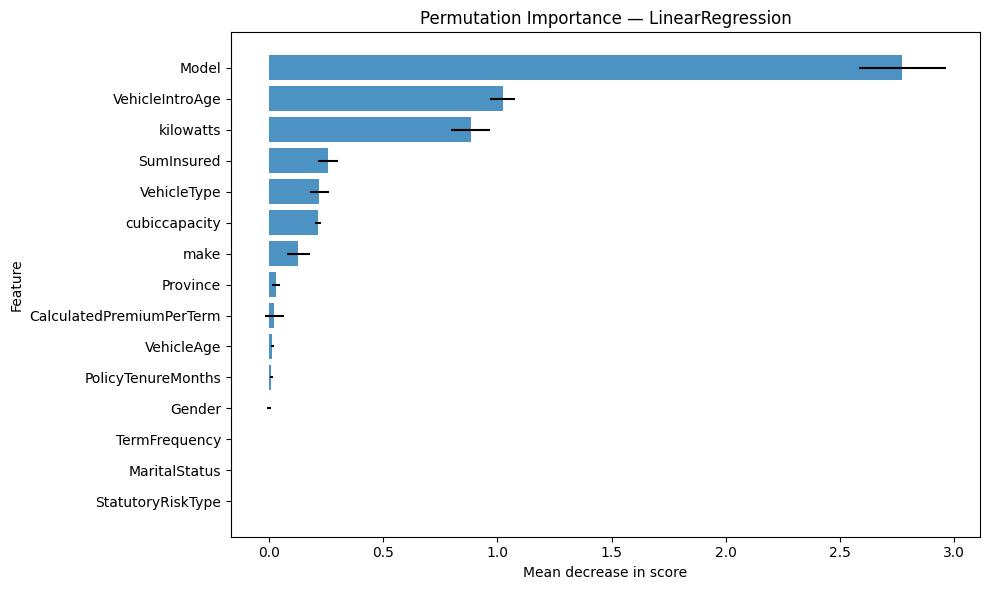

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

if not results_df.empty:
    best_model_name = results_df.iloc[0]["model"]
    best_pipeline = trained_models[best_model_name]
    importance = permutation_importance(
        best_pipeline,
        X_test,
        y_test,
        n_repeats=5,
        random_state=42,
        n_jobs=-1,
    )
    importance_df = (
        pd.DataFrame(
            {
                "feature": X_test.columns,
                "importance_mean": importance.importances_mean,
                "importance_std": importance.importances_std,
            }
        )
        .sort_values("importance_mean", ascending=False)
        .reset_index(drop=True)
    )
    top_n = importance_df.head(15).iloc[::-1]
    std_vals = top_n["importance_std"].fillna(0).to_numpy()
    plt.figure(figsize=(10, 6))
    plt.barh(
        y=top_n["feature"],
        width=top_n["importance_mean"],
        xerr=std_vals,
        color="tab:blue",
        alpha=0.8,
    )
    plt.title(f"Permutation Importance — {best_model_name}")
    plt.xlabel("Mean decrease in score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print("Permutation importance skipped because no models were trained.")

c:\Users\alexo\Desktop\File\10Academy\week3\github\Insurance-Risk-Analytics-And-Predictive-Modeling\.venv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\alexo\Desktop\File\10Academy\week3\github\Insurance-Risk-Analytics-And-Predictive-Modeling\.venv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 9 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid probl

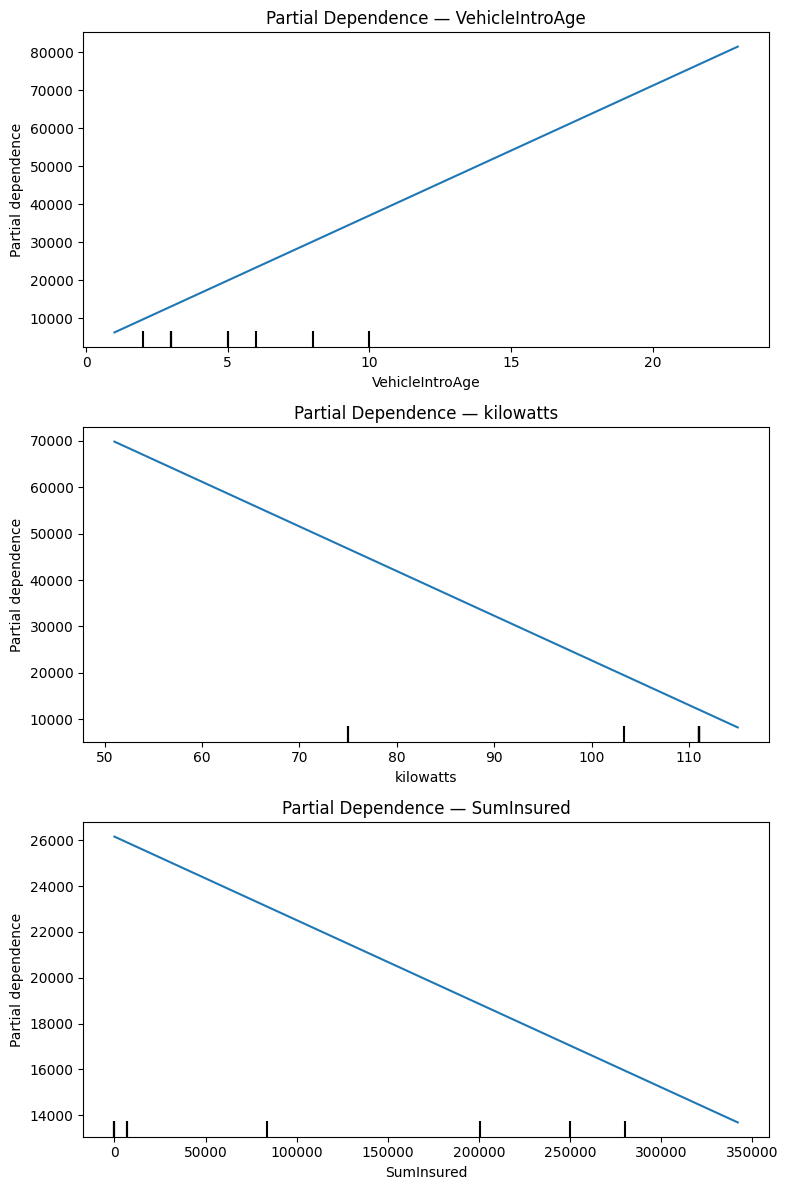

In [7]:
import numpy as np

if not results_df.empty:
    best_model_name = results_df.iloc[0]["model"]
    best_pipeline = trained_models[best_model_name]
    importance = permutation_importance(
        best_pipeline,
        X_test,
        y_test,
        n_repeats=3,
        random_state=42,
        n_jobs=-1,
    )
    ordered_features = (
        pd.Series(importance.importances_mean, index=X_test.columns)
        .sort_values(ascending=False)
        .index
        .tolist()
    )
    numeric_candidates = [
        feature
        for feature in ordered_features
        if pd.api.types.is_numeric_dtype(X_test[feature])
    ]
    if not numeric_candidates:
        print("No numeric features available for PDP.")
    else:
        features_to_plot = numeric_candidates[:3]
        fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(8, 4 * len(features_to_plot)))
        axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]
        for idx, feature in enumerate(features_to_plot):
            PartialDependenceDisplay.from_estimator(
                best_pipeline,
                X_test,
                [feature],
                kind="average",
                ax=axes[idx],
                grid_resolution=20,
            )
            axes[idx].set_title(f"Partial Dependence — {feature}")
        plt.tight_layout()
        plt.show()
else:
    print("PDP skipped because no severity model is available.")

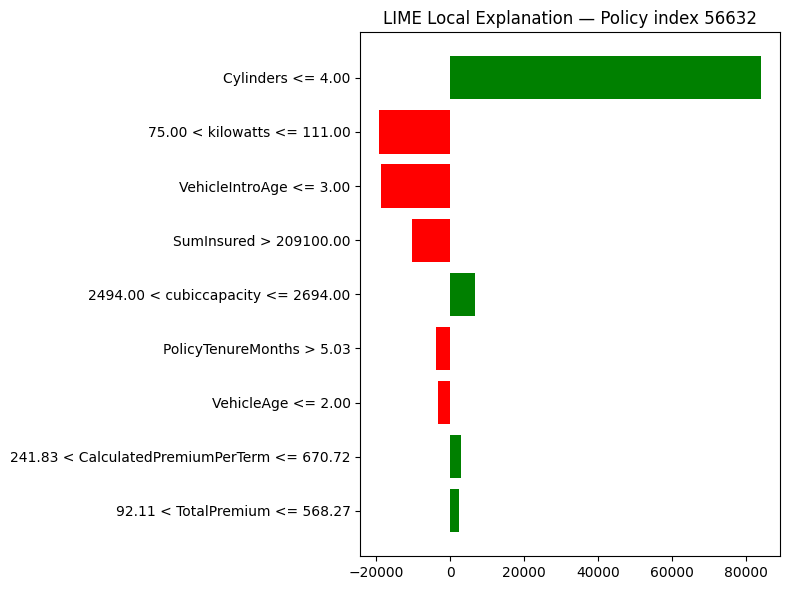

In [9]:
try:
    from lime.lime_tabular import LimeTabularExplainer
except ImportError as exc:
    raise ImportError("Please install lime>=0.2.0 to run this cell") from exc

if not results_df.empty:
    best_model_name = results_df.iloc[0]["model"]
    best_pipeline = trained_models[best_model_name]
    feature_names = X_train.columns.tolist()
    numeric_mask = X_train.apply(pd.api.types.is_numeric_dtype)
    X_train_numeric = X_train.loc[:, numeric_mask].astype(float)
    X_test_numeric = X_test.loc[:, numeric_mask].astype(float)
    feature_names_numeric = X_train_numeric.columns.tolist()
    explainer = LimeTabularExplainer(
        training_data=X_train_numeric.values,
        feature_names=feature_names_numeric,
        mode="regression",
        discretize_continuous=True,
        random_state=42,
    )
    sample = X_test_numeric.sample(1, random_state=42)
    sample_values = sample.values[0]
    def predict_fn(data):
        numeric_df = pd.DataFrame(data, columns=feature_names_numeric)
        combined = pd.concat(
            [numeric_df, X_test.loc[:, ~numeric_mask].reset_index(drop=True)],
            axis=1,
        )
        combined = combined[X_test.columns]
        return best_pipeline.predict(combined)
    explanation = explainer.explain_instance(
        data_row=sample_values,
        predict_fn=predict_fn,
        num_features=10,
    )
    fig = explanation.as_pyplot_figure()
    fig.set_size_inches(8, 6)
    plt.title(f"LIME Local Explanation — Policy index {sample.index[0]}")
    plt.tight_layout()
    plt.show()
else:
    print("LIME explanation skipped because no severity model is available.")

c:\Users\alexo\Desktop\File\10Academy\week3\github\Insurance-Risk-Analytics-And-Predictive-Modeling\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Top 10 Features by SHAP Importance:


,feature,mean_abs_shap
0,cat__Model_QUANTUM 2.7 SESFIKILE 16s,16753.495663
1,num__kilowatts,14864.731561
2,num__VehicleIntroAge,11469.062831
3,cat__Model_QUANTUM 2.7 SESFIKILE 15s,10435.629706
4,num__CalculatedPremiumPerTerm,8338.591309
5,num__TotalPremium,5851.157664
6,cat__Model_QUANTUM 2.7 SESFIKILE 14s,5339.394935
7,cat__Model_HiACE SUPER 16 F/Lift,5174.410550
8,cat__CoverType_Windscreen,4568.256582
9,num__SumInsured,4334.405740


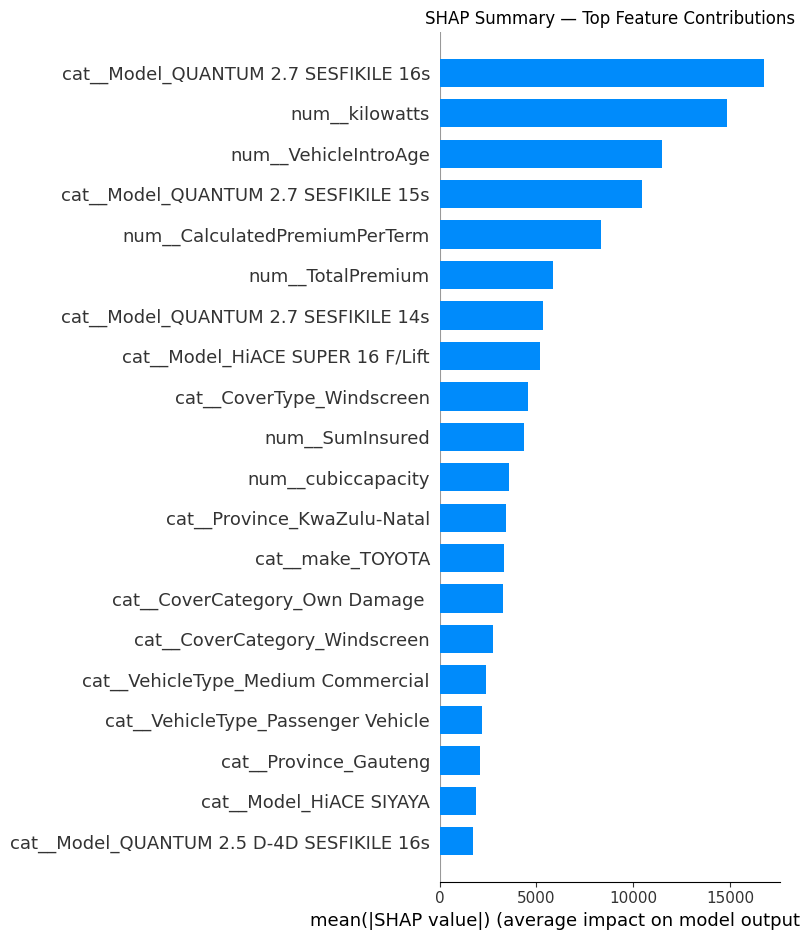

In [10]:
import shap
import numpy as np
import matplotlib.pyplot as plt

if not results_df.empty:
    # Limit background and evaluation sets for performance
    background = X_train.sample(min(500, len(X_train)), random_state=42)
    evaluation_data = X_test.head(200)

    # Transform data using the pipeline's preprocessor
    preprocessor = best_pipeline.named_steps["preprocessor"]
    model = best_pipeline.named_steps["model"]
    
    X_bg_transformed = preprocessor.transform(background)
    X_eval_transformed = preprocessor.transform(evaluation_data)
    
    # Get feature names
    try:
        feature_names = preprocessor.get_feature_names_out()
    except AttributeError:
        feature_names = [f"feature_{i}" for i in range(X_bg_transformed.shape[1])]

    # Use the transformed data to explain the inner model
    explainer = shap.Explainer(model, X_bg_transformed)
    shap_values = explainer(X_eval_transformed)
    
    # Handle Explanation object vs list (for classification) vs array
    if hasattr(shap_values, 'values'):
        vals = shap_values.values
    else:
        vals = shap_values

    # If classification (list of arrays or array with extra dim), take positive class
    if isinstance(vals, list):
        vals = vals[1]
    elif vals.ndim > 2:
        vals = vals[:, :, 1] # Assuming binary classification, index 1 is positive

    shap_importance = (
        pd.DataFrame(
            {
                "feature": feature_names,
                "mean_abs_shap": np.abs(vals).mean(0),
            }
        )
        .sort_values("mean_abs_shap", ascending=False)
        .reset_index(drop=True)
    )

    print("Top 10 Features by SHAP Importance:")
    display(shap_importance.head(10))
    shap.summary_plot(
        vals,
        features=X_eval_transformed,
        feature_names=feature_names,
        plot_type="bar",
        show=False,
    )
    plt.title("SHAP Summary — Top Feature Contributions")
    plt.tight_layout()
    plt.show()
else:
    print("SHAP skipped because severity models are unavailable.")

## Premium Prediction Models

In [11]:
Xp, yp = preprocess_for_premium(df)

Xp_train, Xp_test, yp_train, yp_test = train_test_split_df(
    Xp,
    yp,
    test_size=0.2,
    random_state=42,
)

premium_preprocessor = build_severity_preprocessor(Xp_train)
premium_models = build_default_premium_models()
premium_results_df, premium_trained_models = evaluate_regression_models(
    premium_models,
    Xp_train,
    yp_train,
    Xp_test,
    yp_test,
    premium_preprocessor,
)

premium_formatted = premium_results_df.copy()
if not premium_formatted.empty:
    premium_formatted["rmse"] = premium_formatted["rmse"].map("{:.2f}".format)
    premium_formatted["r2"] = premium_formatted["r2"].map("{:.3f}".format)
premium_formatted

c:\Users\alexo\Desktop\File\10Academy\week3\github\Insurance-Risk-Analytics-And-Predictive-Modeling\src\modeling.py:104: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  - pd.to_datetime(engineered.get('VehicleIntroDate', pd.NaT), errors='coerce').dt.year


,model,rmse,r2
1,RandomForestRegressor,11.33,0.997
2,XGBRegressor,17.15,0.994
0,LinearRegression,54.64,0.942


In [12]:
if not premium_results_df.empty:
    best_premium_model = premium_results_df.iloc[0]["model"]
    best_premium_pipeline = premium_trained_models[best_premium_model]
    premium_preds = best_premium_pipeline.predict(Xp_test)
    premium_mae = mean_absolute_error(yp_test, premium_preds)
    premium_diagnostics = pd.DataFrame(
        {
            "metric": ["rmse", "mae", "r2"],
            "value": [
                premium_results_df.iloc[0]["rmse"],
                premium_mae,
                premium_results_df.iloc[0]["r2"],
            ],
        }
    )
    print(f"Best premium model: {best_premium_model}")
    premium_diagnostics
else:
    print("No premium models evaluated. Check inputs or dependencies.")

Best premium model: RandomForestRegressor


## Claim Probability Classification

In [13]:
Xc, yc = preprocess_for_claim_probability(df)

Xc_train, Xc_test, yc_train, yc_test = train_test_split_df(
    Xc,
    yc,
    test_size=0.2,
    random_state=42,
    stratify=yc,
)

classification_preprocessor = build_severity_preprocessor(Xc_train)
classification_models = build_default_classification_models()
classification_results_df, classification_trained_models = evaluate_classification_models(
    classification_models,
    Xc_train,
    yc_train,
    Xc_test,
    yc_test,
    classification_preprocessor,
)

classification_formatted = classification_results_df.copy()
if not classification_formatted.empty:
    metric_formats = {
        "accuracy": "{:.3f}",
        "precision": "{:.3f}",
        "recall": "{:.3f}",
        "f1": "{:.3f}",
    }
    for metric, format_str in metric_formats.items():
        classification_formatted[metric] = classification_formatted[metric].map(format_str.format)
classification_formatted

c:\Users\alexo\Desktop\File\10Academy\week3\github\Insurance-Risk-Analytics-And-Predictive-Modeling\src\modeling.py:104: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  - pd.to_datetime(engineered.get('VehicleIntroDate', pd.NaT), errors='coerce').dt.year


,model,accuracy,precision,recall,f1
1,RandomForestClassifier,0.989,0.022,0.056,0.031
0,LogisticRegression,0.780,0.013,0.912,0.025
2,XGBClassifier,0.997,0.000,0.000,0.000


In [14]:
if not classification_results_df.empty:
    best_classifier_name = classification_results_df.iloc[0]["model"]
    best_classifier_pipeline = classification_trained_models[best_classifier_name]
    best_classifier_metrics = (
        classification_results_df.iloc[0][["accuracy", "precision", "recall", "f1"]]
        .reset_index()
        .rename(columns={"index": "metric", 0: "value"})
    )
    print(f"Best classifier: {best_classifier_name}")
    best_classifier_metrics
else:
    print("No classification models evaluated. Check inputs or dependencies.")

Best classifier: RandomForestClassifier
